# LLM Judge Evaluation - OpenAI Models Comparison

This notebook evaluates multiple OpenAI models (GPT-4o, GPT-4, GPT-3.5-turbo, etc.) and Claude on their ability to match human evaluations.

## Evaluation Metrics
- **2 points**: Perfect match with human evaluation
- **0 points**: Complete opposite (win vs lose or lose vs win)
- **1 point**: Other cases (partial match, tie comparisons, etc.)

## Models to Compare
- GPT-4o (latest)
- GPT-4
- GPT-3.5-turbo
- Claude-3.5-Sonnet (for comparison)


## Step 1: Import Libraries and Setup


In [22]:
import json
import os
from pathlib import Path
from typing import Dict, List, Optional, Tuple
import pandas as pd
import time
from tqdm import tqdm
import re
import matplotlib.pyplot as plt
import seaborn as sns

# API clients
from openai import OpenAI  # For GPT models
from anthropic import Anthropic  # For Claude

print("Libraries imported successfully")


Libraries imported successfully


In [23]:
# %pip install openai anthropic requests 

## Step 2: Configuration

In [ ]:
# File paths
project_root = Path("/pscratch/sd/s/sixao74/CAI8803/LLM_eval")
prompts_file = project_root / "data_proc" / "arena_judge_prompts.jsonl"
results_dir = project_root / "result"
results_dir.mkdir(exist_ok=True)

# API Configuration
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY", "your-api-key-here")
ANTHROPIC_API_KEY = os.getenv("ANTHROPIC_API_KEY", "your-api-key-here")

# Model configuration - Only include AVAILABLE models
OPENAI_MODELS = [
    "gpt-4o",
    "gpt-4o-mini",
    "gpt-3.5-turbo",
]

# Claude model configuration - List of models to try in order
CLAUDE_MODELS_TO_TRY = [
    "claude-3-5-sonnet-20241022",  # Latest
    "claude-3-5-sonnet-20240620",
    "claude-3-opus-20240229",
    "claude-3-sonnet-20240229",
    "claude-3-haiku-20240307",
]

# Will be set after testing which Claude model is available
CLAUDE_MODEL = None
USE_CLAUDE = False  # Will be set to True if a Claude model is found

# Initialize API clients
openai_client = OpenAI(api_key=OPENAI_API_KEY)

# Test Claude models and find the first available one
print("Testing Claude models...")
print("=" * 60)
anthropic_client = None
if ANTHROPIC_API_KEY:
    try:
        anthropic_client = Anthropic(api_key=ANTHROPIC_API_KEY)
        for model in CLAUDE_MODELS_TO_TRY:
            try:
                # Test with a simple request
                test_response = anthropic_client.messages.create(
                    model=model,
                    max_tokens=10,
                    messages=[{"role": "user", "content": "Say 'test'"}]
                )
                CLAUDE_MODEL = model
                USE_CLAUDE = True
                print(f"✓ Found available Claude model: {CLAUDE_MODEL}")
                break
            except Exception as e:
                error_msg = str(e)
                if "404" in error_msg or "not found" in error_msg.lower():
                    print(f"✗ {model}: Not found")
                else:
                    print(f"? {model}: {error_msg[:80]}")
        if not USE_CLAUDE:
            print("⚠️  No Claude models available. Claude evaluation will be disabled.")
    except Exception as e:
        print(f"⚠️  Error initializing Anthropic client: {e}")
        USE_CLAUDE = False
else:
    print("⚠️  No Anthropic API key found. Claude evaluation will be disabled.")

# Output files
results_file = results_dir / "judge_evaluation_results.jsonl"
summary_file = results_dir / "judge_evaluation_summary.json"
csv_file = results_dir / "judge_evaluation_results.csv"
figure_file = results_dir / "judge_evaluation_results.png"

print(f"\nPrompts file: {prompts_file}")
print(f"Results will be saved to: {results_file}")
print(f"\nModels to evaluate:")
for model in OPENAI_MODELS:
    print(f"  - {model}")
if USE_CLAUDE and CLAUDE_MODEL:
    print(f"  - {CLAUDE_MODEL} (Claude)")
else:
    print("  - Claude: DISABLED (no available model found)")


Testing Claude models...
✗ claude-3-5-sonnet-20241022: Not found
✗ claude-3-5-sonnet-20240620: Not found


/tmp/ipykernel_689934/2242685614.py:44: DeprecationWarning: The model 'claude-3-opus-20240229' is deprecated and will reach end-of-life on January 5th, 2026.
Please migrate to a newer model. Visit https://docs.anthropic.com/en/docs/resources/model-deprecations for more information.
  test_response = anthropic_client.messages.create(
/tmp/ipykernel_689934/2242685614.py:44: DeprecationWarning: The model 'claude-3-sonnet-20240229' is deprecated and will reach end-of-life on July 21st, 2025.
Please migrate to a newer model. Visit https://docs.anthropic.com/en/docs/resources/model-deprecations for more information.
  test_response = anthropic_client.messages.create(


✗ claude-3-opus-20240229: Not found
✗ claude-3-sonnet-20240229: Not found
✓ Found available Claude model: claude-3-haiku-20240307

Prompts file: /pscratch/sd/s/sixao74/CAI8803/LLM_eval/data_proc/arena_judge_prompts.jsonl
Results will be saved to: /pscratch/sd/s/sixao74/CAI8803/LLM_eval/result/judge_evaluation_results.jsonl

Models to evaluate:
  - gpt-4o
  - gpt-4o-mini
  - gpt-3.5-turbo
  - claude-3-haiku-20240307 (Claude)


## Step 3: Load Prompts


In [25]:
def load_prompts(file_path: Path) -> List[Dict]:
    """Load prompts from JSONL file."""
    prompts = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            if line.strip():
                prompts.append(json.loads(line))
    return prompts

prompts = load_prompts(prompts_file)
print(f"Loaded {len(prompts)} prompts")
print(f"\nFirst prompt keys: {list(prompts[0].keys())}")
print(f"\nSample human_winner: {prompts[0]['human_winner']}")
print(f"\nSample prompt preview (first 200 chars):")
print(prompts[0]['prompt'][:200] + "...")


Loaded 100 prompts

First prompt keys: ['id', 'prompt', 'human_winner', 'model_a', 'model_b']

Sample human_winner: tie (bothbad)

Sample prompt preview (first 200 chars):
You are a professional chatbot evaluator. 
Rate both answers on a 0–2 scale for each dimension:
- Relevance (how well it answers the question)
- Informativeness (how detailed and useful it is)
- Clari...


## Step 3.5: Test Model Availability (Optional)

Test which models are available before running the full evaluation.


In [ ]:
# Test model availability
def test_model_availability(model_name: str, test_prompt: str = None) -> bool:
    """Test if a model is available and working."""
    # Use a test prompt that includes "json" to satisfy OpenAI's requirement
    if test_prompt is None:
        test_prompt = 'Return a JSON object with a "status" field set to "ok". Example: {"status": "ok"}'
    
    try:
        response = call_openai(test_prompt, model_name)
        if response:
            print(f"✓ {model_name}: Available")
            return True
        else:
            print(f"✗ {model_name}: Not available or returned None")
            return False
    except Exception as e:
        print(f"✗ {model_name}: Error - {e}")
        return False

# Test Claude models in detail (optional, since we already test in Cell 5)
def test_claude_models_detailed():
    """Test all Claude models and show which ones are available."""
    if not ANTHROPIC_API_KEY or not anthropic_client:
        print("⚠️  No Anthropic API key or client available")
        return {}
    
    available_models = {}
    test_prompt = 'Return a JSON object with "status": "ok"'
    
    print("\n" + "=" * 60)
    print("DETAILED CLAUDE MODEL TESTING")
    print("=" * 60)
    
    for model in CLAUDE_MODELS_TO_TRY:
        try:
            response = anthropic_client.messages.create(
                model=model,
                max_tokens=50,
                temperature=0.0,
                messages=[{"role": "user", "content": test_prompt}]
            )
            available_models[model] = {
                "status": "available",
                "response": response.content[0].text[:100] if response.content else "No response"
            }
            print(f"✓ {model}: Available")
            print(f"  Response preview: {available_models[model]['response'][:50]}...")
        except Exception as e:
            error_msg = str(e)
            error_lower = error_msg.lower()
            
            if "404" in error_msg or "not found" in error_lower:
                available_models[model] = {"status": "not_found", "error": "Model not found"}
                print(f"✗ {model}: Not found (404)")
            elif "quota" in error_lower or "429" in error_msg:
                available_models[model] = {"status": "quota_exceeded", "error": error_msg[:100]}
                print(f"⚠️  {model}: Quota exceeded or rate limited")
            else:
                available_models[model] = {"status": "error", "error": error_msg[:100]}
                print(f"? {model}: {error_msg[:100]}")
        
        time.sleep(0.5)  # Avoid rate limiting
    
    print("\n" + "=" * 60)
    print("SUMMARY")
    print("=" * 60)
    
    available = [m for m, info in available_models.items() if info.get("status") == "available"]
    if available:
        print(f"\n✓ Available Claude models: {', '.join(available)}")
        if CLAUDE_MODEL:
            print(f"  Currently using: {CLAUDE_MODEL}")
    else:
        print("\n✗ No Claude models available")
    
    return available_models

# Test all OpenAI models
print("Testing OpenAI model availability...")
print("=" * 50)
available_models = []
for model in OPENAI_MODELS:
    if test_model_availability(model):
        available_models.append(model)
    time.sleep(0.5)

print(f"\nAvailable OpenAI models: {available_models}")
print(f"\nYou can update OPENAI_MODELS list to only include available models:")
print(f"OPENAI_MODELS = {available_models}")

# Test Claude models in detail (optional)
if USE_CLAUDE and anthropic_client:
    test_claude_models_detailed()


Testing model availability...
✓ gpt-4o: Available
✓ gpt-4o-mini: Available
✓ gpt-3.5-turbo: Available

Available models: ['gpt-4o', 'gpt-4o-mini', 'gpt-3.5-turbo']

You can update OPENAI_MODELS list to only include available models:
OPENAI_MODELS = ['gpt-4o', 'gpt-4o-mini', 'gpt-3.5-turbo']


## Step 4: API Call Functions


In [8]:
def call_claude(prompt: str, model: str = None, max_retries: int = 2) -> Optional[str]:
    """
    Call Anthropic Claude API.
    Automatically tries multiple Claude models if the first one fails.
    """
    if not USE_CLAUDE or not anthropic_client:
        return None
    
    # Use provided model or default to CLAUDE_MODEL
    if model is None:
        model = CLAUDE_MODEL
    
    if model is None:
        return None
    
    # List of models to try (fallback chain)
    models_to_try = [model]
    if model not in CLAUDE_MODELS_TO_TRY:
        # If model is not in the list, add all available models as fallback
        models_to_try.extend(CLAUDE_MODELS_TO_TRY)
    else:
        # Add other models as fallback
        current_idx = CLAUDE_MODELS_TO_TRY.index(model) if model in CLAUDE_MODELS_TO_TRY else -1
        if current_idx >= 0:
            models_to_try.extend(CLAUDE_MODELS_TO_TRY[current_idx + 1:])
    
    # Try each model
    last_error = None
    for model_to_try in models_to_try:
        try:
            response = anthropic_client.messages.create(
                model=model_to_try,
                max_tokens=1024,
                temperature=0.0,
                messages=[
                    {"role": "user", "content": prompt}
                ]
            )
            # If we used a different model than requested, print a note
            if model_to_try != model:
                print(f"  Note: Used Claude model {model_to_try} instead of {model}")
            return response.content[0].text
        except Exception as e:
            error_msg = str(e)
            error_lower = error_msg.lower()
            last_error = e
            
            # Check if it's a model not found error
            is_404 = "404" in error_msg or "not found" in error_lower or "not_found" in error_lower
            
            if is_404:
                # Try next model in the list
                continue
            else:
                # Other error (rate limit, etc.), retry same model if retries left
                if max_retries > 0:
                    time.sleep(1)
                    return call_claude(prompt, model_to_try, max_retries - 1)
                # If no retries left, try next model
                continue
    
    # All models failed
    if last_error:
        error_msg = str(last_error)
        error_lower = error_msg.lower()
        is_404 = "404" in error_msg or "not found" in error_lower
        
        if is_404:
            print(f"  ✗ All Claude models unavailable. Last error: {error_msg[:100]}")
        else:
            print(f"  ✗ Claude API error: {error_msg[:100]}")
    
    return None

print("API call functions defined")


API call functions defined


## Step 5: Parse JSON Response


In [14]:
def parse_winner(response: str) -> Optional[str]:
    """
    Parse winner from LLM response.
    Returns: 'A', 'B', 'tie', or None if parsing fails.
    """
    if not response:
        return None
    
    try:
        # Try to parse as JSON
        data = json.loads(response)
        winner = data.get("winner", "")
        
        # Normalize winner value
        winner = winner.strip().lower()
        if winner in ["a", "model_a"]:
            return "A"
        elif winner in ["b", "model_b"]:
            return "B"
        elif winner == "tie":
            return "tie"
        else:
            # Try to extract from text if not in JSON format
            return extract_winner_from_text(response)
    except json.JSONDecodeError:
        # If not JSON, try to extract from text
        return extract_winner_from_text(response)


def extract_winner_from_text(text: str) -> Optional[str]:
    """Extract winner from text response using regex."""
    text_lower = text.lower()
    
    # Look for winner patterns
    patterns = [
        r'"winner"\s*:\s*["\']([^"\']+)["\']',
        r'winner\s*[:=]\s*["\']?([^"\'\n,}]+)["\']?',
        r'winner\s+is\s+["\']?([^"\'\n.]+)["\']?',
    ]
    
    for pattern in patterns:
        match = re.search(pattern, text_lower)
        if match:
            winner = match.group(1).strip()
            if winner in ["a", "model_a"]:
                return "A"
            elif winner in ["b", "model_b"]:
                return "B"
            elif "tie" in winner:
                return "tie"
    
    # Fallback: check for explicit mentions
    if '"winner": "a"' in text_lower or "'winner': 'a'" in text_lower:
        return "A"
    elif '"winner": "b"' in text_lower or "'winner': 'b'" in text_lower:
        return "B"
    elif "tie" in text_lower:
        return "tie"
    
    return None


# Test parsing function
test_response = '{"A": {"relevance": 2, "informativeness": 2, "clarity": 2, "overall": 2}, "B": {"relevance": 1, "informativeness": 1, "clarity": 1, "overall": 1}, "winner": "A"}'
print(f"Test parsing: {parse_winner(test_response)}")


Test parsing: A


## Step 6: Map Winner to Human Format


In [15]:
def normalize_human_winner(human_winner: str) -> str:
    """
    Normalize human winner to standard format.
    Returns: 'model_a', 'model_b', or 'tie'
    """
    if not human_winner:
        return "tie"
    
    human_winner_lower = human_winner.lower().strip()
    
    # Check for model_a
    if "model_a" in human_winner_lower or human_winner_lower == "a":
        return "model_a"
    
    # Check for model_b
    if "model_b" in human_winner_lower or human_winner_lower == "b":
        return "model_b"
    
    # Everything else is treated as tie
    return "tie"


def map_llm_winner_to_human_format(llm_winner: str, model_a: str, model_b: str) -> str:
    """
    Map LLM winner (A/B/tie) to human format (model_a/model_b/tie).
    """
    if llm_winner == "A":
        return "model_a"
    elif llm_winner == "B":
        return "model_b"
    else:
        return "tie"


# Test mapping
print(f"Normalize 'model_a': {normalize_human_winner('model_a')}")
print(f"Normalize 'tie (bothbad)': {normalize_human_winner('tie (bothbad)')}")
print(f"Map 'A' to human format: {map_llm_winner_to_human_format('A', 'model_a', 'model_b')}")


Normalize 'model_a': model_a
Normalize 'tie (bothbad)': tie
Map 'A' to human format: model_a


## Step 7: Calculate Score


In [16]:
def calculate_score(llm_winner: str, human_winner: str) -> int:
    """
    Calculate score based on matching criteria:
    - 2 points: Perfect match
    - 0 points: Complete opposite (win vs lose or lose vs win)
    - 1 point: Other cases (partial match, tie comparisons, etc.)
    
    Args:
        llm_winner: LLM's predicted winner (model_a/model_b/tie)
        human_winner: Human's ground truth winner (model_a/model_b/tie)
    
    Returns:
        int: Score (0, 1, or 2)
    """
    # Normalize both winners
    llm_normalized = llm_winner.lower().strip() if llm_winner else "unknown"
    human_normalized = normalize_human_winner(human_winner)
    
    # Perfect match: 2 points
    if llm_normalized == human_normalized:
        return 2
    
    # Complete opposite: 0 points
    # model_a vs model_b or model_b vs model_a
    if (llm_normalized == "model_a" and human_normalized == "model_b") or \
       (llm_normalized == "model_b" and human_normalized == "model_a"):
        return 0
    
    # Other cases: 1 point
    # This includes: tie vs model_a, tie vs model_b, model_a vs tie, model_b vs tie
    return 1


# Test scoring
test_cases = [
    ("model_a", "model_a", 2),  # Perfect match
    ("model_b", "model_b", 2),  # Perfect match
    ("tie", "tie", 2),  # Perfect match
    ("model_a", "model_b", 0),  # Complete opposite
    ("model_b", "model_a", 0),  # Complete opposite
    ("model_a", "tie", 1),  # Partial match
    ("tie", "model_a", 1),  # Partial match
    ("model_b", "tie", 1),  # Partial match
    ("tie", "model_b", 1),  # Partial match
]

print("Testing score calculation:")
for llm, human, expected in test_cases:
    score = calculate_score(llm, human)
    status = "✓" if score == expected else "✗"
    print(f"{status} LLM: {llm}, Human: {human}, Score: {score} (expected: {expected})")


Testing score calculation:
✓ LLM: model_a, Human: model_a, Score: 2 (expected: 2)
✓ LLM: model_b, Human: model_b, Score: 2 (expected: 2)
✓ LLM: tie, Human: tie, Score: 2 (expected: 2)
✓ LLM: model_a, Human: model_b, Score: 0 (expected: 0)
✓ LLM: model_b, Human: model_a, Score: 0 (expected: 0)
✓ LLM: model_a, Human: tie, Score: 1 (expected: 1)
✓ LLM: tie, Human: model_a, Score: 1 (expected: 1)
✓ LLM: model_b, Human: tie, Score: 1 (expected: 1)
✓ LLM: tie, Human: model_b, Score: 1 (expected: 1)


In [ ]:
def save_results(results: List[Dict], file_path: Path):
    """Save results to JSONL file."""
    with open(file_path, 'w', encoding='utf-8') as f:
        for result in results:
            f.write(json.dumps(result, ensure_ascii=False) + '\n')


def evaluate_judges(prompts: List[Dict], limit: Optional[int] = None) -> List[Dict]:
    """
    Evaluate all prompts with multiple LLM judges.
    
    Args:
        prompts: List of prompt dictionaries
        limit: Optional limit on number of prompts to evaluate (for testing)
    
    Returns:
        List of evaluation results
    """
    if limit:
        prompts = prompts[:limit]
    
    results = []
    
    for i, prompt_data in enumerate(tqdm(prompts, desc="Evaluating prompts")):
        prompt_id = prompt_data["id"]
        prompt_text = prompt_data["prompt"]
        human_winner = prompt_data["human_winner"]
        model_a = prompt_data.get("model_a", "model_a")
        model_b = prompt_data.get("model_b", "model_b")
        
        result = {
            "id": prompt_id,
            "human_winner": human_winner,
            "model_a": model_a,
            "model_b": model_b,
        }
        
        # Evaluate with each OpenAI model
        for model_name in OPENAI_MODELS:
            try:
                print(f"\n[{i+1}/{len(prompts)}] Evaluating with {model_name}...")
                response = call_openai(prompt_text, model_name)
                
                if response is None:
                    print(f"  Warning: {model_name} returned None, skipping...")
                    # Store None values but continue
                    result_key = model_name.replace("-", "_").replace(".", "_")
                    result[f"{result_key}_response"] = None
                    result[f"{result_key}_winner_raw"] = None
                    result[f"{result_key}_winner"] = None
                    result[f"{result_key}_score"] = 0
                else:
                    winner_raw = parse_winner(response)
                    winner = map_llm_winner_to_human_format(winner_raw, model_a, model_b) if winner_raw else None
                    score = calculate_score(winner, human_winner) if winner else 0
                    
                    # Store results with model name as key
                    result_key = model_name.replace("-", "_").replace(".", "_")
                    result[f"{result_key}_response"] = response
                    result[f"{result_key}_winner_raw"] = winner_raw
                    result[f"{result_key}_winner"] = winner
                    result[f"{result_key}_score"] = score
                
                # Add small delay to avoid rate limiting
                time.sleep(0.2)
            except Exception as e:
                print(f"  Error with {model_name}: {e}")
                # Store error but continue with other models
                result_key = model_name.replace("-", "_").replace(".", "_")
                result[f"{result_key}_response"] = None
                result[f"{result_key}_winner_raw"] = None
                result[f"{result_key}_winner"] = None
                result[f"{result_key}_score"] = 0
                continue
        
        # Evaluate with Claude (if enabled and model available)
        if USE_CLAUDE and CLAUDE_MODEL:
            print(f"Evaluating with Claude ({CLAUDE_MODEL})...")
            claude_response = call_claude(prompt_text, CLAUDE_MODEL)
            claude_winner_raw = parse_winner(claude_response) if claude_response else None
            claude_winner = map_llm_winner_to_human_format(claude_winner_raw, model_a, model_b) if claude_winner_raw else None
            claude_score = calculate_score(claude_winner, human_winner) if claude_winner else 0
            
            result["claude_response"] = claude_response
            result["claude_winner_raw"] = claude_winner_raw
            result["claude_winner"] = claude_winner
            result["claude_score"] = claude_score
            result["claude_model_used"] = CLAUDE_MODEL  # Store which model was actually used
            
            time.sleep(0.2)
        
        results.append(result)
        
        # Save intermediate results every 10 samples
        if (i + 1) % 10 == 0:
            save_results(results, results_file)
            print(f"\n✓ Saved intermediate results after {i+1} samples")
        
        # Add delay to avoid rate limiting
        time.sleep(0.5)
    
    return results


print("Evaluation function defined")


Evaluation function defined


## Step 9: Run Evaluation

**Note**: Start with a small limit for testing, then run the full evaluation.


In [18]:
# Run evaluation
# Set limit=None to evaluate all prompts, or set a small number for testing
# Start with 5-10 samples for testing
evaluation_results = evaluate_judges(prompts, limit=1)  # Change to None for full evaluation

# Save final results
save_results(evaluation_results, results_file)
print(f"\n✓ Evaluation complete! Results saved to {results_file}")
print(f"✓ Evaluated {len(evaluation_results)} prompts")


Evaluating prompts:   0%|          | 0/1 [00:00<?, ?it/s]


[1/1] Evaluating with gpt-4o...

[1/1] Evaluating with gpt-4o-mini...

[1/1] Evaluating with gpt-3.5-turbo...
Evaluating with Claude (claude-3-5-sonnet-20241022)...
  ✗ Claude model claude-3-5-sonnet-20241022 not found. Try: claude-3-5-sonnet-20240620


Evaluating prompts: 100%|██████████| 1/1 [00:05<00:00,  5.73s/it]


✓ Evaluation complete! Results saved to /pscratch/sd/s/sixao74/CAI8803/LLM_eval/result/judge_evaluation_results.jsonl
✓ Evaluated 1 prompts


## Step 10: Calculate Statistics


In [19]:
def calculate_statistics(results: List[Dict]) -> Dict:
    """Calculate statistics for each model."""
    # Get all model names from results
    model_names = OPENAI_MODELS.copy()
    if USE_CLAUDE:
        model_names.append("claude")
    
    stats = {
        "total_samples": len(results),
    }
    
    # Initialize stats for each model
    for model_name in model_names:
        result_key = model_name.replace("-", "_").replace(".", "_")
        stats[result_key] = {
            "scores": [],
            "perfect_matches": 0,
            "opposites": 0,
            "partial_matches": 0,
            "model_name": model_name
        }
    
    # Collect statistics
    for result in results:
        for model_name in model_names:
            result_key = model_name.replace("-", "_").replace(".", "_")
            score_key = f"{result_key}_score"
            
            if score_key in result and result.get(score_key) is not None:
                score = result[score_key]
                stats[result_key]["scores"].append(score)
                if score == 2:
                    stats[result_key]["perfect_matches"] += 1
                elif score == 0:
                    stats[result_key]["opposites"] += 1
                else:
                    stats[result_key]["partial_matches"] += 1
    
    # Calculate averages and accuracy
    for model_name in model_names:
        result_key = model_name.replace("-", "_").replace(".", "_")
        scores = stats[result_key]["scores"]
        if scores:
            stats[result_key]["average_score"] = sum(scores) / len(scores)
            stats[result_key]["total_evaluated"] = len(scores)
            # Accuracy: percentage of perfect matches (2 points)
            stats[result_key]["accuracy"] = stats[result_key]["perfect_matches"] / len(scores) * 100
            # Maximum possible score
            stats[result_key]["max_possible_score"] = len(scores) * 2
            stats[result_key]["total_score"] = sum(scores)
        else:
            stats[result_key]["average_score"] = 0
            stats[result_key]["total_evaluated"] = 0
            stats[result_key]["accuracy"] = 0
            stats[result_key]["max_possible_score"] = 0
            stats[result_key]["total_score"] = 0
    
    return stats


# Load results if they exist (or use current results from previous cell)
try:
    # Try to use evaluation_results from previous cell if it exists
    if 'evaluation_results' not in locals() or not evaluation_results:
        if results_file.exists():
            evaluation_results = []
            with open(results_file, 'r', encoding='utf-8') as f:
                for line in f:
                    if line.strip():
                        evaluation_results.append(json.loads(line))
            print(f"Loaded {len(evaluation_results)} results from file")
        else:
            print("No results available. Please run evaluation first (Step 9).")
            evaluation_results = []
    else:
        print(f"Using {len(evaluation_results)} results from current session")
except NameError:
    # evaluation_results doesn't exist, load from file
    if results_file.exists():
        evaluation_results = []
        with open(results_file, 'r', encoding='utf-8') as f:
            for line in f:
                if line.strip():
                    evaluation_results.append(json.loads(line))
        print(f"Loaded {len(evaluation_results)} results from file")
    else:
        print("No results available. Please run evaluation first (Step 9).")
        evaluation_results = []

# Calculate statistics
if evaluation_results:
    statistics = calculate_statistics(evaluation_results)
    
    # Print statistics
    print("=" * 60)
    print("EVALUATION STATISTICS")
    print("=" * 60)
    print(f"\nTotal samples: {statistics['total_samples']}")
    
    model_names = OPENAI_MODELS.copy()
    if USE_CLAUDE:
        model_names.append("claude")
    
    for model_name in model_names:
        result_key = model_name.replace("-", "_").replace(".", "_")
        if result_key in statistics:
            stats = statistics[result_key]
            print(f"\n{model_name.upper()}:")
            print(f"  Total evaluated: {stats['total_evaluated']}")
            print(f"  Perfect matches (2 pts): {stats['perfect_matches']}")
            print(f"  Partial matches (1 pt): {stats['partial_matches']}")
            print(f"  Complete opposites (0 pts): {stats['opposites']}")
            print(f"  Average score: {stats['average_score']:.2f}")
            print(f"  Total score: {stats['total_score']} / {stats['max_possible_score']}")
            print(f"  Accuracy (perfect match %): {stats['accuracy']:.2f}%")
    
    # Save statistics
    with open(summary_file, 'w', encoding='utf-8') as f:
        json.dump(statistics, f, indent=2, ensure_ascii=False)
    
    print(f"\n✓ Statistics saved to {summary_file}")
else:
    print("No results available. Please run evaluation first.")


Using 1 results from current session
EVALUATION STATISTICS

Total samples: 1

GPT-4O:
  Total evaluated: 1
  Perfect matches (2 pts): 0
  Partial matches (1 pt): 1
  Complete opposites (0 pts): 0
  Average score: 1.00
  Total score: 1 / 2
  Accuracy (perfect match %): 0.00%

GPT-4O-MINI:
  Total evaluated: 1
  Perfect matches (2 pts): 0
  Partial matches (1 pt): 1
  Complete opposites (0 pts): 0
  Average score: 1.00
  Total score: 1 / 2
  Accuracy (perfect match %): 0.00%

GPT-3.5-TURBO:
  Total evaluated: 1
  Perfect matches (2 pts): 1
  Partial matches (1 pt): 0
  Complete opposites (0 pts): 0
  Average score: 2.00
  Total score: 2 / 2
  Accuracy (perfect match %): 100.00%

CLAUDE:
  Total evaluated: 1
  Perfect matches (2 pts): 0
  Partial matches (1 pt): 0
  Complete opposites (0 pts): 1
  Average score: 0.00
  Total score: 0 / 2
  Accuracy (perfect match %): 0.00%

✓ Statistics saved to /pscratch/sd/s/sixao74/CAI8803/LLM_eval/result/judge_evaluation_summary.json


Calculated statistics from current evaluation results
✓ Figure saved to /pscratch/sd/s/sixao74/CAI8803/LLM_eval/result/judge_evaluation_results.png


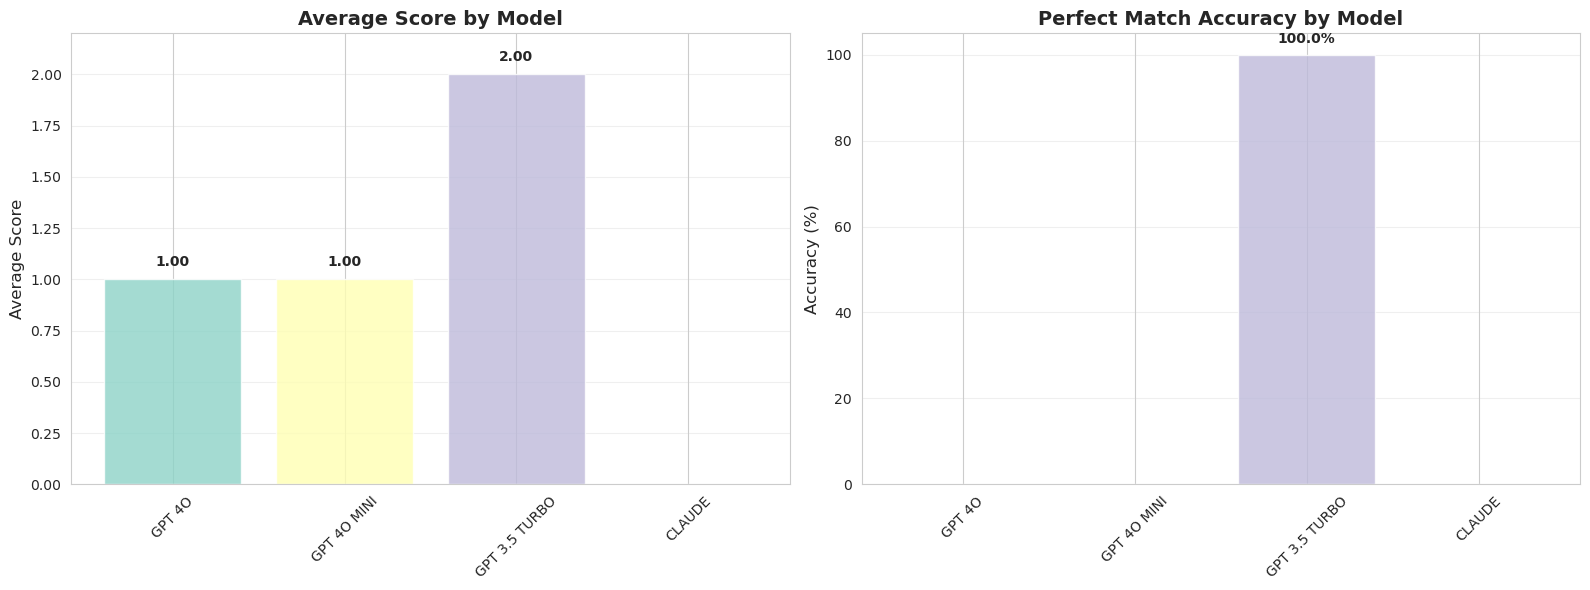

✓ Distribution chart saved to /pscratch/sd/s/sixao74/CAI8803/LLM_eval/result/judge_evaluation_distribution.png


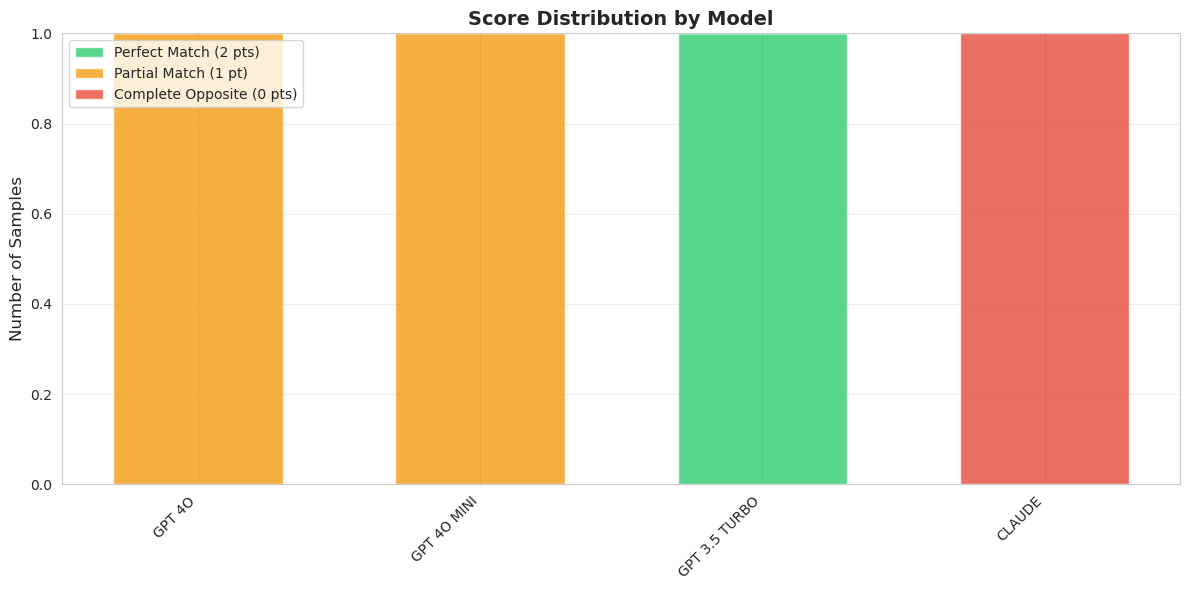

In [20]:
# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

# Load or calculate statistics
statistics = None

# First, try to calculate from current evaluation_results
try:
    if 'evaluation_results' in locals() and evaluation_results:
        statistics = calculate_statistics(evaluation_results)
        print("Calculated statistics from current evaluation results")
except NameError:
    pass

# If not available, load from file
if statistics is None and summary_file.exists():
    with open(summary_file, 'r', encoding='utf-8') as f:
        statistics = json.load(f)
    print(f"Loaded statistics from {summary_file}")

# Create visualization if we have statistics
if statistics:
    # Get model names and display names
    model_names = OPENAI_MODELS.copy()
    if USE_CLAUDE:
        model_names.append("claude")
    
    display_names = [name.upper().replace("-", " ") for name in model_names]
    
    # Create visualization
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Prepare data
    avg_scores = []
    accuracies = []
    
    for model_name in model_names:
        result_key = model_name.replace("-", "_").replace(".", "_")
        if result_key in statistics and statistics[result_key]["total_evaluated"] > 0:
            avg_scores.append(statistics[result_key]["average_score"])
            accuracies.append(statistics[result_key]["accuracy"])
        else:
            avg_scores.append(0)
            accuracies.append(0)
    
    # Plot 1: Average scores
    colors = plt.cm.Set3(range(len(model_names)))
    bars1 = axes[0].bar(display_names, avg_scores, color=colors, alpha=0.8)
    axes[0].set_ylabel('Average Score', fontsize=12)
    axes[0].set_title('Average Score by Model', fontsize=14, fontweight='bold')
    axes[0].set_ylim(0, 2.2)
    axes[0].grid(axis='y', alpha=0.3)
    axes[0].tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for i, (bar, score) in enumerate(zip(bars1, avg_scores)):
        if score > 0:
            axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05, 
                        f'{score:.2f}', ha='center', va='bottom', fontweight='bold')
    
    # Plot 2: Accuracy (perfect match percentage)
    bars2 = axes[1].bar(display_names, accuracies, color=colors, alpha=0.8)
    axes[1].set_ylabel('Accuracy (%)', fontsize=12)
    axes[1].set_title('Perfect Match Accuracy by Model', fontsize=14, fontweight='bold')
    axes[1].set_ylim(0, 105)
    axes[1].grid(axis='y', alpha=0.3)
    axes[1].tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for i, (bar, acc) in enumerate(zip(bars2, accuracies)):
        if acc > 0:
            axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
                        f'{acc:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    
    # Save figure
    plt.savefig(figure_file, dpi=300, bbox_inches='tight')
    print(f"✓ Figure saved to {figure_file}")
    
    plt.show()
    
    # Create additional detailed comparison chart
    fig2, ax = plt.subplots(figsize=(12, 6))
    
    # Prepare data for stacked bar chart
    perfect_counts = []
    partial_counts = []
    opposite_counts = []
    
    for model_name in model_names:
        result_key = model_name.replace("-", "_").replace(".", "_")
        if result_key in statistics:
            perfect_counts.append(statistics[result_key]["perfect_matches"])
            partial_counts.append(statistics[result_key]["partial_matches"])
            opposite_counts.append(statistics[result_key]["opposites"])
        else:
            perfect_counts.append(0)
            partial_counts.append(0)
            opposite_counts.append(0)
    
    # Stacked bar chart
    x = range(len(display_names))
    width = 0.6
    p1 = ax.bar(x, perfect_counts, width, label='Perfect Match (2 pts)', color='#2ecc71', alpha=0.8)
    p2 = ax.bar(x, partial_counts, width, bottom=perfect_counts, label='Partial Match (1 pt)', color='#f39c12', alpha=0.8)
    p3 = ax.bar(x, opposite_counts, width, bottom=[p + part for p, part in zip(perfect_counts, partial_counts)], 
                label='Complete Opposite (0 pts)', color='#e74c3c', alpha=0.8)
    
    ax.set_ylabel('Number of Samples', fontsize=12)
    ax.set_title('Score Distribution by Model', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(display_names, rotation=45, ha='right')
    ax.legend(loc='upper left')
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(results_dir / "judge_evaluation_distribution.png", dpi=300, bbox_inches='tight')
    print(f"✓ Distribution chart saved to {results_dir / 'judge_evaluation_distribution.png'}")
    plt.show()
else:
    print(f"No statistics available. Please run evaluation and statistics calculation first.")


In [21]:
# Create detailed DataFrame for analysis
# Try to get evaluation_results from previous cells or load from file
try:
    if 'evaluation_results' not in locals() or not evaluation_results:
        if results_file.exists():
            evaluation_results = []
            with open(results_file, 'r', encoding='utf-8') as f:
                for line in f:
                    if line.strip():
                        evaluation_results.append(json.loads(line))
            print(f"Loaded {len(evaluation_results)} results from file")
        else:
            evaluation_results = []
            print("No results available. Please run evaluation first.")
except NameError:
    if results_file.exists():
        evaluation_results = []
        with open(results_file, 'r', encoding='utf-8') as f:
            for line in f:
                if line.strip():
                    evaluation_results.append(json.loads(line))
        print(f"Loaded {len(evaluation_results)} results from file")
    else:
        evaluation_results = []
        print("No results available. Please run evaluation first.")

if evaluation_results:
    
    df = pd.DataFrame(evaluation_results)
    
    # Display sample results
    print("Sample Results:")
    # Get score columns
    score_cols = [col for col in df.columns if col.endswith('_score')]
    winner_cols = [col for col in df.columns if col.endswith('_winner') and not col.endswith('_winner_raw')]
    display_cols = ["id", "human_winner"] + winner_cols + score_cols
    available_cols = [col for col in display_cols if col in df.columns]
    print(df[available_cols].head(10))
    
    # Confusion matrices for each model
    print("\n" + "=" * 60)
    print("CONFUSION MATRICES")
    print("=" * 60)
    
    model_names = OPENAI_MODELS.copy()
    if USE_CLAUDE:
        model_names.append("claude")
    
    for model_name in model_names:
        result_key = model_name.replace("-", "_").replace(".", "_")
        winner_col = f"{result_key}_winner"
        if winner_col in df.columns:
            print(f"\n{model_name.upper()} Confusion Matrix:")
            confusion = pd.crosstab(
                df["human_winner"].apply(normalize_human_winner),
                df[winner_col].fillna("unknown"),
                margins=True
            )
            print(confusion)
    
    # Save detailed results to CSV
    df.to_csv(csv_file, index=False, encoding='utf-8')
    print(f"\n✓ Detailed results saved to {csv_file}")
    print(f"✓ Total rows: {len(df)}")
    print(f"✓ Columns: {len(df.columns)}")
else:
    print(f"No results file found at {results_file}. Please run evaluation first.")


Sample Results:
                                 id   human_winner   human_winner  \
0  dc49665013564b499ccc51865ab0c3da  tie (bothbad)  tie (bothbad)   

  gpt_4o_winner gpt_4o_mini_winner gpt_3_5_turbo_winner claude_winner  \
0       model_b            model_b                  tie          None   

   gpt_4o_score  gpt_4o_mini_score  gpt_3_5_turbo_score  claude_score  
0             1                  1                    2             0  

CONFUSION MATRICES

GPT-4O Confusion Matrix:
gpt_4o_winner  model_b  All
human_winner               
tie                  1    1
All                  1    1

GPT-4O-MINI Confusion Matrix:
gpt_4o_mini_winner  model_b  All
human_winner                    
tie                       1    1
All                       1    1

GPT-3.5-TURBO Confusion Matrix:
gpt_3_5_turbo_winner  tie  All
human_winner                  
tie                     1    1
All                     1    1

CLAUDE Confusion Matrix:
claude_winner  unknown  All
human_winner          